# **Grade feature properties**

Now we have got all the feature properties. Now we will try to rank features as per the attribute values and hence find the optimum locations as per the scores

##### **Install and Import Libraries**

In [1]:
!apt install python3-rtree --quiet
!pip install geopandas
!pip install contextily

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Get:5 http:

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
import seaborn as sns
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler

##### **Read the data**

In [3]:
houses_features = pd.read_csv('content/houses_features.csv')
houses_features.head(5)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,DOLLAR PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MSL,LATITUDE,LONGITUDE,geometry,Groceries,Restaurants,Hospitals,Bars,Fuel stations,Public_transport,Parks,Schools
0,MLS Listing,Townhouse,6813 NW 163rd Ave,Portland,OR,97229,535000,4,2.5,Arbor Lakes,1922,2613,2014,2,278,212,Active,http://www.redfin.com/OR/Portland/6813-NW-163r...,RMLS,21056418,45.568689,-122.845517,POINT (-13675100.42094033 5711498.624231413),17,100,1,7,22,360,163,44
1,PAST SALE,Single Family Residential,2525 NW Arnott Ln,Portland,OR,97229,629900,4,2.5,IRON RIDGE PARK,2324,4791,2011,318,271,30,Sold,http://www.redfin.com/OR/Portland/2525-NW-Arno...,RMLS,20264930,45.537885,-122.795329,POINT (-13669513.4515447 5706601.712189261),32,243,3,20,38,778,199,70
2,PAST SALE,Single Family Residential,4561 NW Continental Pl,Beaverton,OR,97006,450000,3,2.5,NW Washington Co or Sauvie Island,1518,2613,2000,183,296,75,Sold,http://www.redfin.com/OR/Beaverton/4561-NW-Con...,RMLS,21067322,45.552848,-122.850795,POINT (-13675687.8872891 5708980.155521237),23,127,1,12,26,464,206,57
3,PAST SALE,Single Family Residential,1123 NW 93rd Ave,Portland,OR,97229,490000,4,2.5,NW Washington Co or Sauvie Island,1853,3049,2011,1534,264,48,Sold,http://www.redfin.com/OR/Portland/1123-NW-93rd...,RMLS,17684940,45.527355,-122.773088,POINT (-13667037.66154166 5704928.415160857),32,290,3,40,39,991,236,83
4,PAST SALE,Single Family Residential,12781 NW Forest Spring Ln,Portland,OR,97229,590000,4,2.5,BAUER HIGHLANDS,2416,4356,2001,1123,244,20,Sold,http://www.redfin.com/OR/Portland/12781-NW-For...,RMLS,18208993,45.550917,-122.808786,POINT (-13671011.55585595 5708673.140444201),26,189,3,15,32,571,170,58


##### **Apply weights**

We will apply weights to the columns to give them importance. As each attribute will affect the output differently.

In [10]:
def add_weights(row):
    weights = ((row['PRICE']*-1.5) + # penalize by 1.5 times
             (row['BEDS']*1)+
             (row['BATHS']*1)+
             (row['SQUARE FEET']*1)+
             (row['LOT SIZE']*1)+
             (row['YEAR BUILT']*1)+
             (row['HOA PER MONTH']*-1)+  # penalize by 1 times
             (row['Groceries']*1)+
             (row['Restaurants']*1)+
             (row['Hospitals']*1.5)+  # reward by 1.5 times
             (row['Bars']*1)+
             (row['Fuel stations']*1)+
             (row['Public_transport']*1.5)+  # reward by 1.5 times
             (row['Parks']*1)+
             (row['Schools']*1))
    return weights

houses_features['score'] = houses_features.apply(add_weights, axis=1)

NameError: name 'houses_features' is not defined

In [5]:
houses_features.head(5)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,DOLLAR PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MSL,LATITUDE,LONGITUDE,geometry,Groceries,Restaurants,Hospitals,Bars,Fuel stations,Public_transport,Parks,Schools,score
0,MLS Listing,Townhouse,6813 NW 163rd Ave,Portland,OR,97229,535000,4,2.5,Arbor Lakes,1922,2613,2014,2,278,212,Active,http://www.redfin.com/OR/Portland/6813-NW-163r...,RMLS,21056418,45.568689,-122.845517,POINT (-13675100.42094033 5711498.624231413),17,100,1,7,22,360,163,44,-795262.0
1,PAST SALE,Single Family Residential,2525 NW Arnott Ln,Portland,OR,97229,629900,4,2.5,IRON RIDGE PARK,2324,4791,2011,318,271,30,Sold,http://www.redfin.com/OR/Portland/2525-NW-Arno...,RMLS,20264930,45.537885,-122.795329,POINT (-13669513.4515447 5706601.712189261),32,243,3,20,38,778,199,70,-933974.0
2,PAST SALE,Single Family Residential,4561 NW Continental Pl,Beaverton,OR,97006,450000,3,2.5,NW Washington Co or Sauvie Island,1518,2613,2000,183,296,75,Sold,http://www.redfin.com/OR/Beaverton/4561-NW-Con...,RMLS,21067322,45.552848,-122.850795,POINT (-13675687.8872891 5708980.155521237),23,127,1,12,26,464,206,57,-667790.0
3,PAST SALE,Single Family Residential,1123 NW 93rd Ave,Portland,OR,97229,490000,4,2.5,NW Washington Co or Sauvie Island,1853,3049,2011,1534,264,48,Sold,http://www.redfin.com/OR/Portland/1123-NW-93rd...,RMLS,17684940,45.527355,-122.773088,POINT (-13667037.66154166 5704928.415160857),32,290,3,40,39,991,236,83,-725917.5
4,PAST SALE,Single Family Residential,12781 NW Forest Spring Ln,Portland,OR,97229,590000,4,2.5,BAUER HIGHLANDS,2416,4356,2001,1123,244,20,Sold,http://www.redfin.com/OR/Portland/12781-NW-For...,RMLS,18208993,45.550917,-122.808786,POINT (-13671011.55585595 5708673.140444201),26,189,3,15,32,571,170,58,-874889.5


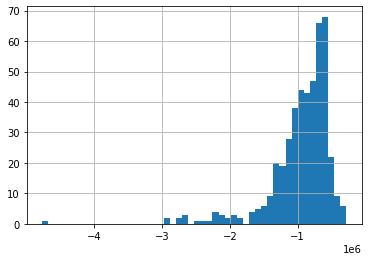

In [6]:
# Plot a histogram for the score column
houses_features['score'].hist(bins=50); 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


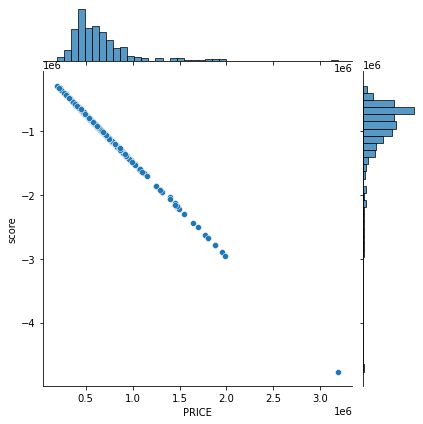

In [7]:
# Plot two variables using bivariate or univariate graphs using seaborn library
sns.jointplot('PRICE','score', data=houses_features)

##### **Scale the data**

If you see on the above plot we can see that column with large values like Price of property has less importance in the scoring. To solve this we will scale the data. For scaling we will use sklearn MinMaxScaler function

In [8]:
mm_scaler = MinMaxScaler()

In [9]:
#Take out list of columns to be scaled
scale_cols = ['PRICE', 'BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', 'HOA PER MONTH','Groceries','Restaurants','Hospitals','Bars','Fuel stations','Public_transport','Parks','Schools']

In [10]:
scaled_array = mm_scaler.fit_transform(houses_features[scale_cols])
houses_features_scaled = pd.DataFrame(scaled_array, columns=scale_cols)
houses_features_scaled.head(5)

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA PER MONTH,Groceries,Restaurants,Hospitals,Bars,Fuel stations,Public_transport,Parks,Schools
0,0.113887,0.4,0.230769,0.160589,0.052144,0.666667,0.526582,0.144928,0.066028,0.090909,0.010345,0.223881,0.069182,0.356481,0.120
1,0.145501,0.4,0.230769,0.215908,0.095624,0.523810,0.065823,0.362319,0.218317,0.272727,0.055172,0.462687,0.288260,0.523148,0.328
2,0.085572,0.2,0.230769,0.104995,0.052144,0.000000,0.179747,0.231884,0.094782,0.090909,0.027586,0.283582,0.123690,0.555556,0.224
3,0.098897,0.4,0.230769,0.151094,0.060848,0.523810,0.111392,0.362319,0.268371,0.272727,0.124138,0.477612,0.399895,0.694444,0.432
4,0.132209,0.4,0.230769,0.228567,0.086940,0.047619,0.040506,0.275362,0.160809,0.272727,0.037931,0.373134,0.179769,0.388889,0.232


In [11]:
#Calculates score with scaled data
houses_features_scaled['scores_scaled'] = houses_features_scaled.apply(add_weights, axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


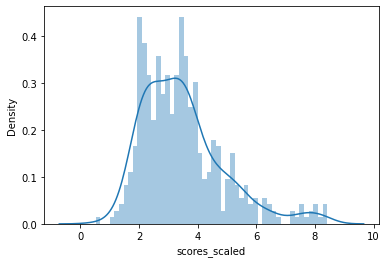

In [12]:
# Density plot for the scaled data shows normal distribution of data after scaling
sns.distplot(houses_features_scaled['scores_scaled'], bins=50)

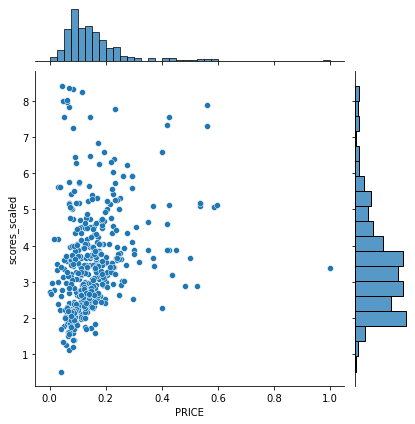

In [13]:
# Joint plot on scaled score and Price
sns.jointplot(x='PRICE', y='scores_scaled', data=houses_features_scaled)

##### **Extract top 50 properties based on the scores**

In [14]:
# First we will append the scores to the original csv
houses_features['score'] = houses_features_scaled['scores_scaled']
houses_features.head(5)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,DOLLAR PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MSL,LATITUDE,LONGITUDE,geometry,Groceries,Restaurants,Hospitals,Bars,Fuel stations,Public_transport,Parks,Schools,score
0,MLS Listing,Townhouse,6813 NW 163rd Ave,Portland,OR,97229,535000,4,2.5,Arbor Lakes,1922,2613,2014,2,278,212,Active,http://www.redfin.com/OR/Portland/6813-NW-163r...,RMLS,21056418,45.568689,-122.845517,POINT (-13675100.42094033 5711498.624231413),17,100,1,7,22,360,163,44,1.974555
1,PAST SALE,Single Family Residential,2525 NW Arnott Ln,Portland,OR,97229,629900,4,2.5,IRON RIDGE PARK,2324,4791,2011,318,271,30,Sold,http://www.redfin.com/OR/Portland/2525-NW-Arno...,RMLS,20264930,45.537885,-122.795329,POINT (-13669513.4515447 5706601.712189261),32,243,3,20,38,778,199,70,3.973161
2,PAST SALE,Single Family Residential,4561 NW Continental Pl,Beaverton,OR,97006,450000,3,2.5,NW Washington Co or Sauvie Island,1518,2613,2000,183,296,75,Sold,http://www.redfin.com/OR/Beaverton/4561-NW-Con...,RMLS,21067322,45.552848,-122.850795,POINT (-13675687.8872891 5708980.155521237),23,127,1,12,26,464,206,57,2.019092
3,PAST SALE,Single Family Residential,1123 NW 93rd Ave,Portland,OR,97229,490000,4,2.5,NW Washington Co or Sauvie Island,1853,3049,2011,1534,264,48,Sold,http://www.redfin.com/OR/Portland/1123-NW-93rd...,RMLS,17684940,45.527355,-122.773088,POINT (-13667037.66154166 5704928.415160857),32,290,3,40,39,991,236,83,4.474601
4,PAST SALE,Single Family Residential,12781 NW Forest Spring Ln,Portland,OR,97229,590000,4,2.5,BAUER HIGHLANDS,2416,4356,2001,1123,244,20,Sold,http://www.redfin.com/OR/Portland/12781-NW-For...,RMLS,18208993,45.550917,-122.808786,POINT (-13671011.55585595 5708673.140444201),26,189,3,15,32,571,170,58,2.901947


In [15]:
houses_sorted = houses_features.sort_values(by='score', ascending=False)
houses_sorted.head(5)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,DOLLAR PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MSL,LATITUDE,LONGITUDE,geometry,Groceries,Restaurants,Hospitals,Bars,Fuel stations,Public_transport,Parks,Schools,score
245,PAST SALE,Townhouse,5827 NE Center Commons Way,Portland,OR,97213,327500,3,2.0,Portland Northeast,1223,871,2001,1083,268,225,Sold,http://www.redfin.com/OR/Portland/5827-NE-Cent...,RMLS,18237730,45.527075,-122.603117,POINT (-13648116.53184424 5704883.828279532),76,977,8,294,72,2136,302,154,8.417653
229,PAST SALE,Townhouse,4738 SW View Point Ter,Portland,OR,97239,400000,3,3.5,"Portland West, Raleigh Hills",1856,1742,2002,823,216,32,Sold,http://www.redfin.com/OR/Portland/4738-SW-View...,RMLS,19551645,45.489019,-122.677936,POINT (-13656445.3670898 5698838.946592222),56,826,11,236,57,1945,301,120,8.360675
228,PAST SALE,Townhouse,715 NE Tillamook St,Portland,OR,97212,439000,3,3.0,Irvington,1498,871,2005,635,293,100,Sold,http://www.redfin.com/OR/Portland/715-NE-Tilla...,RMLS,19439512,45.537653,-122.658228,POINT (-13654251.4936972 5706564.840849998),61,934,10,266,66,2024,271,113,8.324428
232,PAST SALE,Townhouse,723 NE Tillamook St,Portland,OR,97212,545000,3,3.0,Portland Northeast,1155,1306,2005,64,472,100,Sold,http://www.redfin.com/OR/Portland/723-NE-Tilla...,RMLS,21248091,45.537653,-122.658115,POINT (-13654238.90346279 5706564.840849998),61,933,10,266,66,2026,271,113,8.233453
240,PAST SALE,Townhouse,4742 SW View Point Ter,Portland,OR,97239,380000,2,2.5,"Portland West, Raleigh Hills",1872,2178,2002,1422,203,29,Sold,http://www.redfin.com/OR/Portland/4742-SW-View...,RMLS,17256601,45.488966,-122.677937,POINT (-13656445.4784093 5698830.48305841),55,825,11,235,57,1946,302,120,8.021733


In [16]:
# Resetted index and added rank column will have index value as per descending score value i.e 1 rank will have highest score
houses_sorted.reset_index(drop=True, inplace=True)
houses_sorted['rank'] = houses_sorted.index + 1 # + 1 to start rank from 1
houses_sorted

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,DOLLAR PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MSL,LATITUDE,LONGITUDE,geometry,Groceries,Restaurants,Hospitals,Bars,Fuel stations,Public_transport,Parks,Schools,score,rank
0,PAST SALE,Townhouse,5827 NE Center Commons Way,Portland,OR,97213,327500,3,2.0,Portland Northeast,1223,871,2001,1083,268,225,Sold,http://www.redfin.com/OR/Portland/5827-NE-Cent...,RMLS,18237730,45.527075,-122.603117,POINT (-13648116.53184424 5704883.828279532),76,977,8,294,72,2136,302,154,8.417653,1
1,PAST SALE,Townhouse,4738 SW View Point Ter,Portland,OR,97239,400000,3,3.5,"Portland West, Raleigh Hills",1856,1742,2002,823,216,32,Sold,http://www.redfin.com/OR/Portland/4738-SW-View...,RMLS,19551645,45.489019,-122.677936,POINT (-13656445.3670898 5698838.946592222),56,826,11,236,57,1945,301,120,8.360675,2
2,PAST SALE,Townhouse,715 NE Tillamook St,Portland,OR,97212,439000,3,3.0,Irvington,1498,871,2005,635,293,100,Sold,http://www.redfin.com/OR/Portland/715-NE-Tilla...,RMLS,19439512,45.537653,-122.658228,POINT (-13654251.4936972 5706564.840849998),61,934,10,266,66,2024,271,113,8.324428,3
3,PAST SALE,Townhouse,723 NE Tillamook St,Portland,OR,97212,545000,3,3.0,Portland Northeast,1155,1306,2005,64,472,100,Sold,http://www.redfin.com/OR/Portland/723-NE-Tilla...,RMLS,21248091,45.537653,-122.658115,POINT (-13654238.90346279 5706564.840849998),61,933,10,266,66,2026,271,113,8.233453,4
4,PAST SALE,Townhouse,4742 SW View Point Ter,Portland,OR,97239,380000,2,2.5,"Portland West, Raleigh Hills",1872,2178,2002,1422,203,29,Sold,http://www.redfin.com/OR/Portland/4742-SW-View...,RMLS,17256601,45.488966,-122.677937,POINT (-13656445.4784093 5698830.48305841),55,825,11,235,57,1946,302,120,8.021733,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,PAST SALE,Townhouse,16174 NW Fescue Ct,Portland,OR,97229,335000,3,2.5,Sommerset West-Elmonica N,1480,1742,2000,1507,226,186,Sold,http://www.redfin.com/OR/Portland/16174-NW-Fes...,RMLS,17586139,45.564260,-122.843094,POINT (-13674830.66041829 5710794.40348963),18,104,1,7,22,397,175,49,1.338834,455
455,PAST SALE,Townhouse,16228 NW Fescue Ct Unit End,Portland,OR,97229,373500,3,2.5,NW Washington Co or Sauvie Island,1576,3049,2001,380,237,250,Sold,http://www.redfin.com/OR/Portland/16228-NW-Fes...,RMLS,20300882,45.564156,-122.844109,POINT (-13674943.67196534 5710777.883081577),18,103,1,7,22,395,176,49,1.246485,456
456,MLS Listing,Townhouse,16185 NW Fescue Ct,Portland,OR,97229,439900,3,2.5,SPRINGVILLE MEADOWS,1832,871,2001,11,240,252,Active,http://www.redfin.com/OR/Portland/16185-NW-Fes...,RMLS,21217643,45.564607,-122.843350,POINT (-13674859.15820793 5710849.609540692),18,103,1,7,22,394,176,49,1.199204,457
457,MLS Listing,Townhouse,16104 NW Fescue Ct,Portland,OR,97229,399950,3,2.5,BETHANY,1480,1742,2000,2,270,249,Active,http://www.redfin.com/OR/Portland/16104-NW-Fes...,RMLS,21629739,45.564503,-122.842111,POINT (-13674721.23335884 5710833.120831295),18,103,1,7,22,397,174,48,1.133191,458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  """


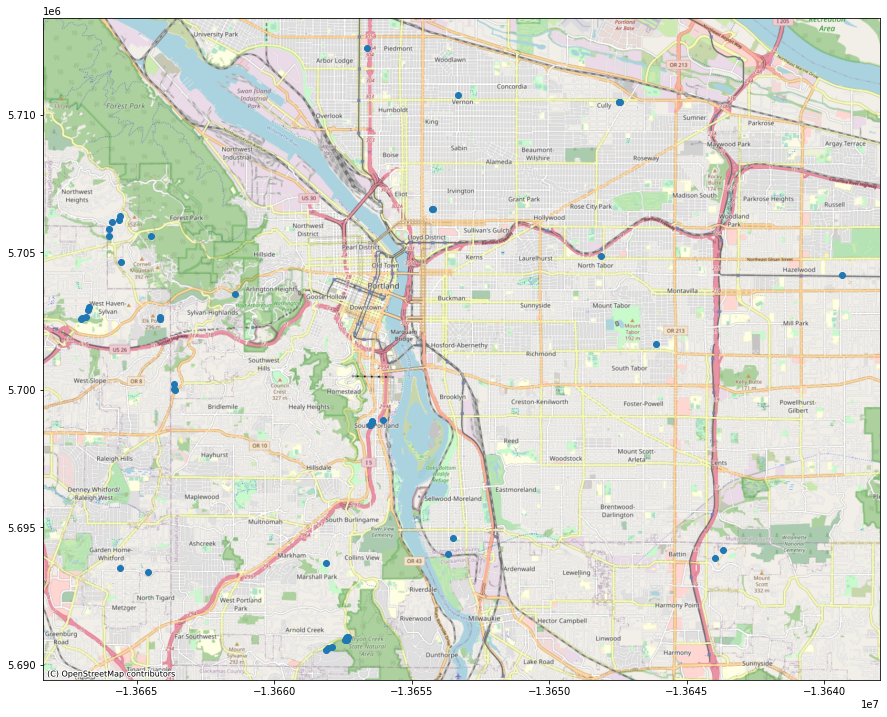

In [17]:
# Let's visualize top 10 properties on map
houses_sorted_gdf = gpd.GeoDataFrame(houses_sorted,crs='epsg:4326', geometry=gpd.points_from_xy(x=houses_sorted.LONGITUDE, y=houses_sorted.LATITUDE)) 
houses_sorted_gdf = houses_sorted_gdf.to_crs('epsg:3857')
ax = houses_sorted_gdf[:50].plot( figsize=(15, 15))
ctx.add_basemap(ax,url = ctx.providers.OpenStreetMap.Mapnik)

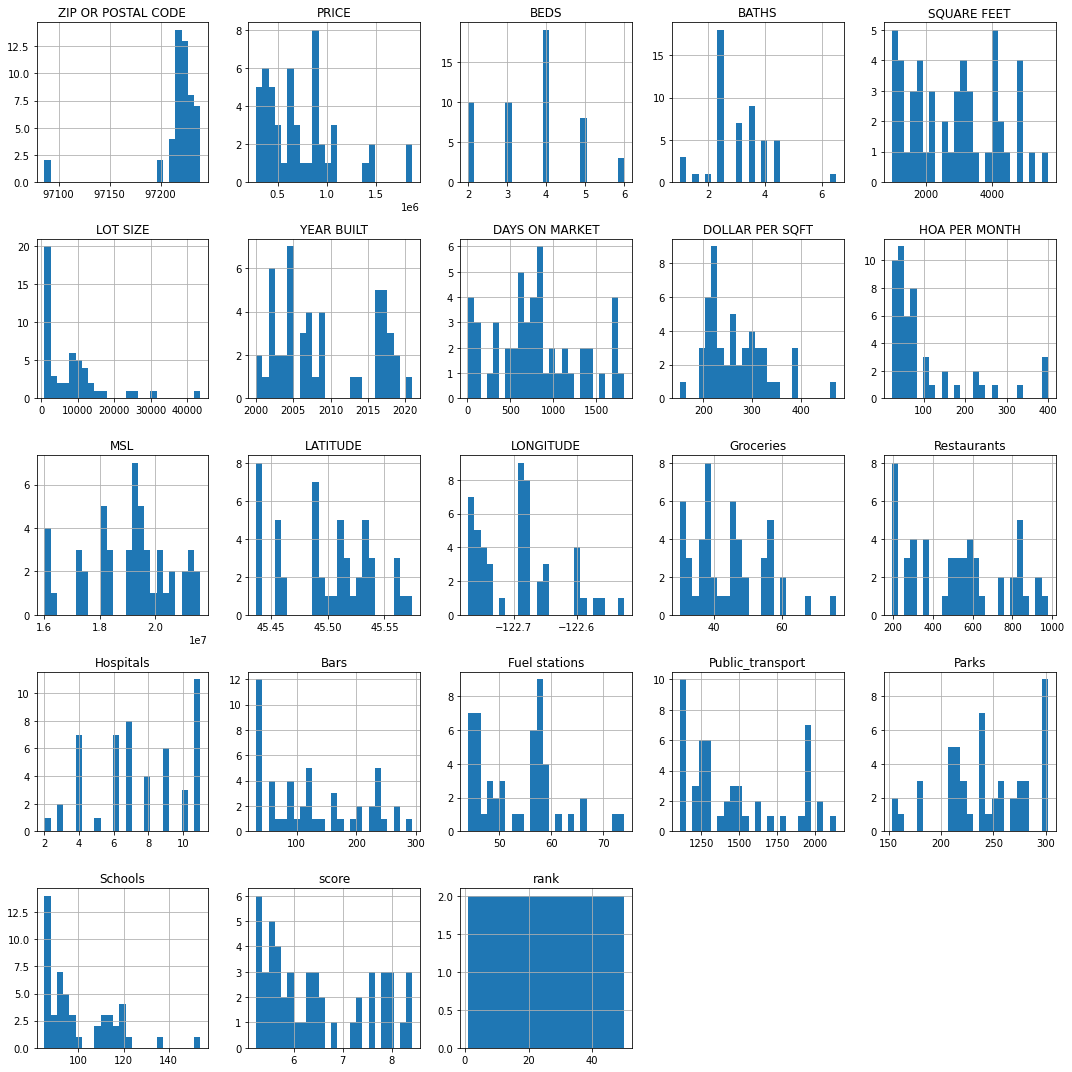

In [18]:
# Lets see the histogram for all these 50 properties
ax_list = houses_sorted[:50].hist(bins=25, layout=(5,5), figsize=(15,15))
plt.tight_layout()

##### **Save to disk**

In [19]:
houses_sorted_gdf[:50].to_csv('top_50_real_estate_properties.csv',index=False)
houses_sorted_gdf[:50].to_file('top_50_real_estate_properties.geojson',driver='GeoJSON')

# **Conclusion**

Based on the inferences above you can say that these 50 properties are most suitable to invest in due to good connectivity with amenities , comparatively less prices and less HOA as well.

For calculating undervalued properties we can add layers of new development plan in the city and try to find time required as well as distance from the new infrastructures the plan will incorporate.